## Process the European Grape Harvest Data from the initial data files downloaded from NOAA Paleoclimate:

https://www.ncdc.noaa.gov/cdo/f?p=519:1:0::::P1_STUDY_ID:13194


## Tasks:

* Convert all GHD data to day of year anomalies relative to the mean calculated from 1600-1900.
* Create the GHD-Core and GHD-ALL composite average indices.
* Calculate cross site correlations between the different regional GHD series.
* Calculate various summary statistics (mean, standard deviation, serial completion) of the different series for different time intervals.
* Plot up GHD-Core and GHD-All, including plots comparing the individual series against GHD-Core.
* Create histograms and conduct some statistical testing to compare recent GHD anomalies in GHD-Core against previous intervals.
* Save all the new data to new files to be used for subsequent analyses.

## Setup
* Reset the workspace.
* Load all the different modules I will need. 
* Setup some basic variables: column labels for some data frames and vectors for different year ranges that I will analyze. 
* Set the name/directory of the initial GHD file that I am going to grab the data from.

In [143]:
# Reset the environment (start clean)
%reset -f

# Setup the Analysis
import calendar
import datetime
import numpy as np
import netCDF4
import os
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from IPython.display import display
from mpl_toolkits.basemap import Basemap, cm

from matplotlib import interactive
interactive(True)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# Last year in np.arange is excluded
#     Generate year vectors for exploratory analyses over different time periods
base_period      = np.arange(1600,1901)   # baseline period for anomaly calculation
period_1600_1980 = np.arange(1600,1981)   # 1600-1980
period_1901_1950 = np.arange(1901,1951)   # 1951-1980
period_1951_1980 = np.arange(1951,1981)   # 1951-1980
period_1981_2007 = np.arange(1981,2008)   # 1981-2007

# Column Headers for Time Span Specific Data Frames
col_txt=["1600-1900","1600-1980","1901-1950","1951-1980","1981-2007"]

# Other Variables
mon=np.arange(1,9)                   # month vector, used for converting to DOY               
infile = '../data/europe2012ghd.csv' # Name of the original data file

## Original Grape Harvest Date (GHD)
* Read the initial GHD data file into a pandas dataframe.
* Rename the columns and strip off the header rows.
* Pull out the year vector and GHD array into numpy arrays.

In [144]:
# Dataframe adjustments
# Import the original Daux data into a dataframe
df=pd.read_csv(infile)

# Rename Columns
df.columns = df.loc[2,:]
df=df.rename(columns = {'Abb.':'Year'})

# Delete Header Rows
df = df.drop(df.index[:3])

# Make the Index the 'Year' and then Drop from the Dataframe
df.index = df.loc[:,'Year']
del(df['Year'])

# Pull out year series and convert to 64 float precision. These are the variables
# I will operate on.
yr  = np.int64(df.index)
ghd = np.float64(df.loc[:,:])

## Constructing the GHD-Core Index
* Here, I will set and pull out the specific regional GHD datasets that I will use to construct the GHD-Core index.
* NOTE: In the original dataset, Cha1 is MISLABELLED as Cha2. To keep things consistent, I use the Cha2 nomenclature throughout all my code (but refer to this site as Cha1 in the main manuscript)

In [145]:
# Pull out Specific sites for the core index
core_names=['Als','Bor','Bur','Cha2','Lan','LLV','SRv','Swi']

# Create dummy index for core site loactions.
print("Sites used in GHD-Core:")
core_locs=np.int64(np.zeros(np.size(core_names)))

# Find locations for these series in the dataframe
for loop_series in enumerate(core_names):
    print(loop_series)
    core_locs[loop_series[0]] = np.int64(np.where(df.columns==loop_series[1])[0])

# Locations in the data frame
print("")
print("GHD-Core Site Column Locations")
print(core_locs)


Sites used in GHD-Core:
(0, 'Als')
(1, 'Bor')
(2, 'Bur')
(3, 'Cha2')
(4, 'Lan')
(5, 'LLV')
(6, 'SRv')
(7, 'Swi')

GHD-Core Site Column Locations
[ 0  4  5  7 13 14 23 24]


## Convert to DOY Anomaly
* The initial GHD data are in units of days relative to August 31. In this cell, I will convert them to units of "day of year" (Jan 1 = 1, Jan 2 = 2, etc...)

In [146]:
# New ghd matrix that will be converted to day of year
ghd_doy=copy.deepcopy(ghd) # need to use copy statement to make a proper copy of a variable

# Convert to Day of Year from Day relative to August 31
for loop_yr in enumerate(yr):
    
    # Year index and current year
    i_yr = loop_yr[0]; curr_yr = loop_yr[1];       

    # Initialize day of year for August 31   
    doy_aug31 = 0
    
    # Month Loop-January to August
    for loop_mon in enumerate(mon):        
        # Month Index and Current Month      
        i_mon = loop_mon[0]; curr_mon = loop_mon[1];       
        # Add days to doy_aug31
        doy_aug31=doy_aug31+calendar.monthrange(curr_yr,curr_mon)[1]

    # Convert GHD to DOY     
    ghd_doy[i_yr,:]=ghd_doy[i_yr,:]+doy_aug31


## Anomaly Calculation and Summary Statistics
* For each record in Daux:
* convert to anomalies (day of year), relative to the mean over 1600-1900.
* calculate some summary statistics (mean, st. dev.) for different intervals

In [147]:
# Loop through Each record and calculate anomaly relative to the base period

# Find location of years for different averaging periods
yr_loc_base      = np.where((yr>=np.min(base_period))      & (yr<=np.max(base_period)))[0];      # convert from tuple to array
yr_loc_1600_1980 = np.where((yr>=np.min(period_1600_1980)) & (yr<=np.max(period_1600_1980)))[0]; # convert from tuple to array
yr_loc_1901_1950 = np.where((yr>=np.min(period_1901_1950)) & (yr<=np.max(period_1901_1950)))[0]; # convert from tuple to array
yr_loc_1951_1980 = np.where((yr>=np.min(period_1951_1980)) & (yr<=np.max(period_1951_1980)))[0]; # convert from tuple to array
yr_loc_1981_2007 = np.where((yr>=np.min(period_1981_2007)) & (yr<=np.max(period_1981_2007)))[0]; # convert from tuple to array

# New Array for Anomalies
ghd_doy_anom = copy.deepcopy(ghd_doy)

# Initialize Array to Store All GHD
mean_ghd_allsites = np.float64(np.zeros(np.size(df.columns)))

# Initialize Array to Store All Standard Deviations/Mean Values
std_record       = np.float64(np.zeros((np.size(df.columns),5)))
mean_record      = np.float64(np.zeros((np.size(df.columns),5)))
mean_anom_record = np.float64(np.zeros((np.size(df.columns),5)))

# Loop through each record and subtract the mean from the baseline period: Total Anomaly, all series
for loop_record in np.arange(np.size(df.columns)):
    
    # Calculate Mean Date for the base period
    mean_ghd=np.nanmean(ghd_doy[yr_loc_base,loop_record])
    
    # ABSOLUTE DATE Calculate Mean for Each site and time period (DOY, NOT anomaly)
    mean_record[loop_record,0] = np.nanmean(ghd_doy_anom[yr_loc_base,loop_record])      # 1600-1900
    mean_record[loop_record,1] = np.nanmean(ghd_doy_anom[yr_loc_1600_1980,loop_record]) # 1600-1980
    mean_record[loop_record,2] = np.nanmean(ghd_doy_anom[yr_loc_1901_1950,loop_record]) # 1901-1950
    mean_record[loop_record,3] = np.nanmean(ghd_doy_anom[yr_loc_1951_1980,loop_record]) # 1951-1980
    mean_record[loop_record,4] = np.nanmean(ghd_doy_anom[yr_loc_1981_2007,loop_record]) # 1981-2007
    
    # Calculate the anomaly for each year, relative to the mean date
    ghd_doy_anom[:,loop_record]=ghd_doy_anom[:,loop_record]-mean_ghd

    # ANOMALOUS DATE Calculate Mean for Each site and time period (ANOMALY)
    mean_anom_record[loop_record,0] = np.nanmean(ghd_doy_anom[yr_loc_base,loop_record])      # 1600-1900
    mean_anom_record[loop_record,1] = np.nanmean(ghd_doy_anom[yr_loc_1600_1980,loop_record]) # 1600-1980
    mean_anom_record[loop_record,2] = np.nanmean(ghd_doy_anom[yr_loc_1901_1950,loop_record]) # 1901-1950
    mean_anom_record[loop_record,3] = np.nanmean(ghd_doy_anom[yr_loc_1951_1980,loop_record]) # 1951-1980
    mean_anom_record[loop_record,4] = np.nanmean(ghd_doy_anom[yr_loc_1981_2007,loop_record]) # 1981-2007

    # Calculate StDev for Each site and time period
    std_record[loop_record,0] = np.nanstd(ghd_doy_anom[yr_loc_base,loop_record])      # 1600-1900
    std_record[loop_record,1] = np.nanstd(ghd_doy_anom[yr_loc_1600_1980,loop_record]) # 1600-1980
    std_record[loop_record,2] = np.nanstd(ghd_doy_anom[yr_loc_1901_1950,loop_record]) # 1901-1950
    std_record[loop_record,3] = np.nanstd(ghd_doy_anom[yr_loc_1951_1980,loop_record]) # 1951-1980
    std_record[loop_record,4] = np.nanstd(ghd_doy_anom[yr_loc_1981_2007,loop_record]) # 1981-2007
    
    del mean_ghd

# Make a New Dataframe for the mean and std GHD for Core Sites
df_mean_coresites      = pd.DataFrame(mean_record[core_locs,:],      index=core_names, columns=col_txt)
df_mean_anom_coresites = pd.DataFrame(mean_anom_record[core_locs,:], index=core_names, columns=col_txt)
df_std_coresites       = pd.DataFrame(std_record[core_locs,:],       index=core_names, columns=col_txt)    

## Display tables of these summary statistics

In [148]:
print("Mean Date, Core Sites (DOY)")
print("Supplementary Table 1")
(df_mean_coresites)

Mean Date, Core Sites (DOY)
Supplementary Table 1


,1600-1900,1600-1980,1901-1950,1951-1980,1981-2007
Als,282.809770,281.871730,272.118182,287.160000,277.696000
Bor,269.006667,268.221455,263.846000,270.410000,259.746154
Bur,269.921333,270.071164,269.441667,272.576667,262.146154
Cha2,266.878205,267.518471,267.008163,270.016667,264.923077
Lan,272.427225,270.283071,260.969697,266.876667,263.400000
LLV,286.115000,284.605085,282.693878,282.557143,275.326923
SRv,269.198630,269.097238,268.835000,268.460000,257.865385
Swi,286.390365,283.865617,273.856000,275.216667,263.000000


In [149]:
print("Mean Date ANOMALY, Core Sites (DOY)")
print("Supplementary Table 4")
(df_mean_anom_coresites)

Mean Date ANOMALY, Core Sites (DOY)
Supplementary Table 4


,1600-1900,1600-1980,1901-1950,1951-1980,1981-2007
Als,-9.800589e-16,-0.938040,-10.691588,4.350230,-5.113770
Bor,9.036646e-15,-0.785212,-5.160667,1.403333,-9.260513
Bur,-7.579123e-16,0.149831,-0.479667,2.655333,-7.775179
Cha2,-6.449542e-14,0.640266,0.129958,3.138462,-1.955128
Lan,-1.130916e-14,-2.144154,-11.457528,-5.550558,-9.027225
LLV,5.115908e-15,-1.509915,-3.421122,-3.557857,-10.788077
SRv,-6.229416e-15,-0.101393,-0.363630,-0.738630,-11.333246
Swi,-2.096219e-14,-2.524749,-12.534365,-11.173699,-23.390365


In [150]:
print("Standard Deviation of Harvest Date, Core Sites")
print("Supplementary Table 5")
(df_std_coresites)

Standard Deviation of Harvest Date, Core Sites
Supplementary Table 5


,1600-1900,1600-1980,1901-1950,1951-1980,1981-2007
Als,8.742338,9.564765,9.121651,7.085553,8.736429
Bor,9.510065,9.004488,6.274654,7.003444,9.562597
Bur,9.606724,9.191084,6.545095,8.113515,7.966286
Cha2,8.808164,8.879324,7.851968,10.122157,8.637677
Lan,8.633570,9.027141,6.514017,5.693721,5.388946
LLV,10.291184,9.211435,6.559629,8.006445,7.412544
SRv,8.676124,8.457554,8.619587,5.549090,5.929648
Swi,10.085469,10.710933,7.186325,6.679725,8.112131


## Calculate number of observations/serial completion of each regional GHD series in Daux for various time periods.

In [151]:
# Calculate Serial Completion for Each GHD Time Series
obs_exist = np.float64(~np.isnan(ghd_doy_anom))   # Boolean array indicating missing values or not
#obs_exist = np.float64(obs_exist)     # Convert Boolean array to 1s and 0s

# Initialize Arrays to store Number of Observations for different time periods
num_obs_val = np.float64(np.zeros((27,5)))
num_obs_pct = np.float64(np.zeros((27,5)))

# Calculate Serial Completion----------

# Total Number of Observations
num_obs_val[:,0] = np.nansum(obs_exist[:,:],axis=0);                  
num_obs_pct[:,0] = np.divide(num_obs_val[:,0],np.size(yr))

# Number of observations during the baseline period
num_obs_val[:,1] = np.nansum(obs_exist[yr_loc_base,:],axis=0);        
num_obs_pct[:,1] = np.divide(num_obs_val[:,1],np.size(yr_loc_base))

# Number of Observations After 1600
yr_loc_temp = np.where(yr>=1600)[0]
num_obs_val[:,2] = np.nansum(obs_exist[yr_loc_temp,:],axis=0); 
num_obs_pct[:,2] = np.divide(num_obs_val[:,2],np.size(yr_loc_temp))

# Number of Observations After 1800
yr_loc_temp = np.where(yr>=1800)[0]
num_obs_val[:,3] = np.nansum(obs_exist[yr_loc_temp,:],axis=0); 
num_obs_pct[:,3] = np.divide(num_obs_val[:,3],np.size(yr_loc_temp))

# Number of Observations After 1900
yr_loc_temp = np.where(yr>=1900)[0]
num_obs_val[:,4] = np.nansum(obs_exist[yr_loc_temp,:],axis=0); 
num_obs_pct[:,4] = np.divide(num_obs_val[:,4],np.size(yr_loc_temp))

# Create Dataframes
header_txt = [np.str(np.min(yr))+'-'+np.str(np.max(yr)),np.str(np.min(base_period))+'-'+np.str(np.max(base_period)),'1600-2007','1800-2007','1900-2007']
df_num_obs_all = pd.DataFrame(num_obs_val,index=df.columns.tolist(),columns=header_txt)
df_pct_obs_all = pd.DataFrame(num_obs_pct,index=df.columns.tolist(),columns=header_txt)

In [152]:
print('Number of Observations, All GHD Series')
df_num_obs_all

Number of Observations, All GHD Series


,1354-2007,1600-1900,1600-2007,1800-2007,1900-2007
Als,262,174,262,174,89
Auv,80,80,80,79,0
Aux,128,128,128,80,0
Bea,73,9,73,73,65
Bor,327,195,301,207,107
Bur,605,300,404,205,105
Cha1,81,81,81,80,0
Cha2,183,78,183,183,106
Gai,73,55,55,0,0
Ger,198,198,198,28,0


In [153]:
print('% of Observations, All GHD Series')
df_pct_obs_all

% of Observations, All GHD Series


,1354-2007,1600-1900,1600-2007,1800-2007,1900-2007
Als,0.400612,0.578073,0.642157,0.836538,0.824074
Auv,0.122324,0.265781,0.196078,0.379808,0.000000
Aux,0.195719,0.425249,0.313725,0.384615,0.000000
Bea,0.111621,0.029900,0.178922,0.350962,0.601852
Bor,0.500000,0.647841,0.737745,0.995192,0.990741
Bur,0.925076,0.996678,0.990196,0.985577,0.972222
Cha1,0.123853,0.269103,0.198529,0.384615,0.000000
Cha2,0.279817,0.259136,0.448529,0.879808,0.981481
Gai,0.111621,0.182724,0.134804,0.000000,0.000000
Ger,0.302752,0.657807,0.485294,0.134615,0.000000


In [154]:
print('% of Observations, Core Sites Only')
print('Supplemental Table 2')
df_pct_obs_all.loc[core_names,:]

% of Observations, Core Sites Only
Supplemental Table 2


,1354-2007,1600-1900,1600-2007,1800-2007,1900-2007
Als,0.400612,0.578073,0.642157,0.836538,0.824074
Bor,0.500000,0.647841,0.737745,0.995192,0.990741
Bur,0.925076,0.996678,0.990196,0.985577,0.972222
Cha2,0.279817,0.259136,0.448529,0.879808,0.981481
Lan,0.441896,0.634551,0.688725,0.437500,0.833333
LLV,0.310398,0.332226,0.497549,0.975962,0.962963
SRv,0.689602,0.970100,0.950980,0.942308,0.898148
Swi,0.749235,1.000000,1.000000,1.000000,1.000000


## Plots up the individual time series for GHD-Core and for GHD-All (based on all the regional series.

(1600, 2007)

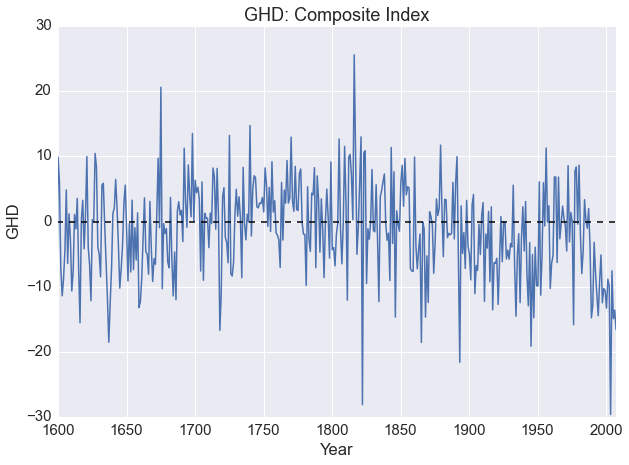

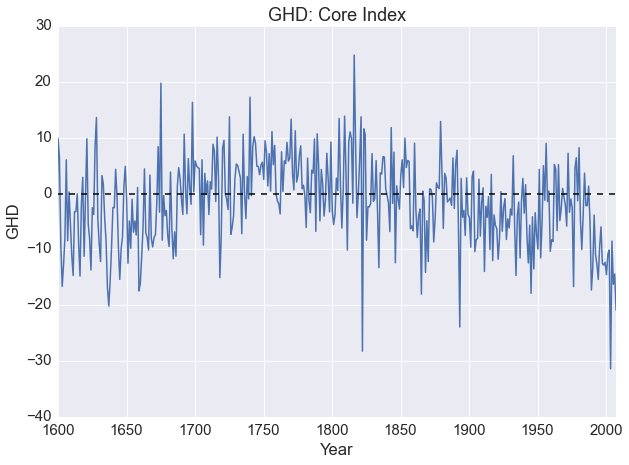

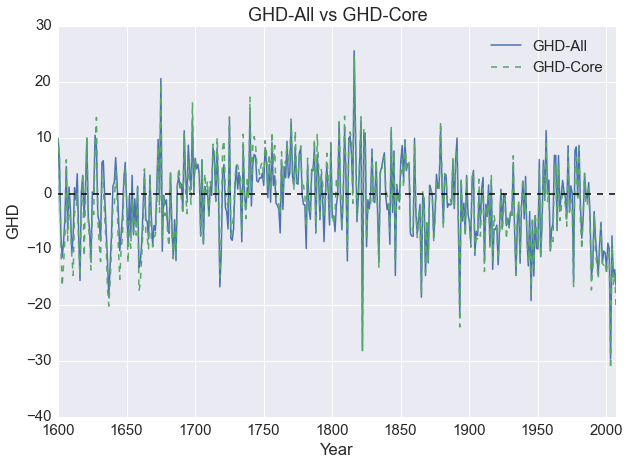

In [155]:
# Create and plot Average Index   
ghd_mean_all  = np.nanmean(ghd_doy_anom,axis=1) 
ghd_mean_core = np.nanmean(ghd_doy_anom[:,core_locs],axis=1) 
     
# Line of Zeros
line_zero = np.zeros(np.size(yr))   
     
# Figure for Composite Index
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7])
sns.plt.plot(yr,ghd_mean_all)
sns.plt.plot(yr,line_zero,'--', color='k')
sns.plt.xlabel('Year')
sns.plt.ylabel('GHD')
sns.plt.title('GHD: Composite Index')
sns.plt.tight_layout
sns.plt.xlim(1600,2007)
#sns.plt.savefig('./figures/step01/ghd_composite_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
#sns.plt.savefig('../figures/step01/ghd_composite_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 

# Figure for Core Index
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7])
sns.plt.plot(yr,ghd_mean_core)
sns.plt.plot(yr,line_zero,'--', color='k')
sns.plt.xlabel('Year')
sns.plt.ylabel('GHD')
sns.plt.title('GHD: Core Index')
sns.plt.tight_layout
sns.plt.xlim(1600,2007)
#sns.plt.savefig('./figures/step01/ghd_core_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator     
#sns.plt.savefig('../figures/step01/ghd_core_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator     
       
# Figure for Composite AND Core Index
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7])
sns.plt.plot(yr,ghd_mean_all)
sns.plt.plot(yr,ghd_mean_core,'--')
sns.plt.plot(yr,line_zero,'--', color='k')
sns.plt.xlabel('Year')
sns.plt.ylabel('GHD')
sns.plt.title('GHD-All vs GHD-Core')
sns.plt.legend(['GHD-All','GHD-Core'])
sns.plt.tight_layout
sns.plt.xlim(1600,2007)
#sns.plt.savefig('./figures/step01/ghd_core_and_comp_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
#sns.plt.savefig('../figures/step01/ghd_core_and_ghd_all_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 

## Create a Dataframe for the GHD-Core anomaly index. Then, print out the values for some interesting years. 

In [156]:
# Dataframe
df_new= pd.DataFrame(ghd_mean_core, index=yr, columns={'GHDcore'})

# Print GHD Anomalies for 2003 and 2007 (earliest from most recent period)
print('---------------------------')
print('DOY Anomalies, Select Years')
print('---------------------------')
print('GHD-Core, 1816: '+np.str(df_new.GHDcore[1816]))
print('GHD-Core, 1822: '+np.str(df_new.GHDcore[1822]))
print('GHD-Core, 1893: '+np.str(df_new.GHDcore[1893]))
print('GHD-Core, 2003: '+np.str(df_new.GHDcore[2003]))
print('GHD-Core, 2007: '+np.str(df_new.GHDcore[2007]))

---------------------------
DOY Anomalies, Select Years
---------------------------
GHD-Core, 1816: 24.8263723833
GHD-Core, 1822: -28.2314244041
GHD-Core, 1893: -23.9028529755
GHD-Core, 2003: -31.3933994949
GHD-Core, 2007: -20.9087952897


## Calculate Summary Statistics for the GHD-Core and GHD-All Series

In [157]:
# Initialize Array to Store All Standard Deviations/Mean Values
mean_core_comp = np.float64(np.zeros((5,2)))
std_core_comp  = np.float64(np.zeros((5,2)))
       
# MEAN, Core/Comp Index
mean_core_comp[0,0] = np.nanmean(ghd_mean_core[yr_loc_base]);      mean_core_comp[0,1] = np.nanmean(ghd_mean_all[yr_loc_base]);      
mean_core_comp[1,0] = np.nanmean(ghd_mean_core[yr_loc_1600_1980]); mean_core_comp[1,1] = np.nanmean(ghd_mean_all[yr_loc_1600_1980]);      
mean_core_comp[2,0] = np.nanmean(ghd_mean_core[yr_loc_1901_1950]); mean_core_comp[2,1] = np.nanmean(ghd_mean_all[yr_loc_1901_1950]);      
mean_core_comp[3,0] = np.nanmean(ghd_mean_core[yr_loc_1951_1980]); mean_core_comp[3,1] = np.nanmean(ghd_mean_all[yr_loc_1951_1980]);      
mean_core_comp[4,0] = np.nanmean(ghd_mean_core[yr_loc_1981_2007]); mean_core_comp[4,1] = np.nanmean(ghd_mean_all[yr_loc_1981_2007]);      

# St. Deviation, Core/Comp Index
std_core_comp[0,0] = np.nanstd(ghd_mean_core[yr_loc_base]);      std_core_comp[0,1] = np.nanstd(ghd_mean_all[yr_loc_base]);      
std_core_comp[1,0] = np.nanstd(ghd_mean_core[yr_loc_1600_1980]); std_core_comp[1,1] = np.nanstd(ghd_mean_all[yr_loc_1600_1980]);      
std_core_comp[2,0] = np.nanstd(ghd_mean_core[yr_loc_1901_1950]); std_core_comp[2,1] = np.nanstd(ghd_mean_all[yr_loc_1901_1950]);      
std_core_comp[3,0] = np.nanstd(ghd_mean_core[yr_loc_1951_1980]); std_core_comp[3,1] = np.nanstd(ghd_mean_all[yr_loc_1951_1980]);      
std_core_comp[4,0] = np.nanstd(ghd_mean_core[yr_loc_1981_2007]); std_core_comp[4,1] = np.nanstd(ghd_mean_all[yr_loc_1981_2007]);      

# Put this info into Dataframes
# Indices/Label
col_core_comp_txt=["GHD-Core","GHD-Comp"]
row_core_comp_txt=["1600-1900","1600-1980","1901-1950","1951-1980","1981-2007"]

# Create Data Frames
df_mean_core_comp = pd.DataFrame(mean_core_comp, index=row_core_comp_txt, columns=col_core_comp_txt)
df_std_core_comp  = pd.DataFrame(std_core_comp, index=row_core_comp_txt, columns=col_core_comp_txt)

print("Mean GHD Anomalies")
print("Supplementary Table 4")
df_mean_core_comp


Mean GHD Anomalies
Supplementary Table 4


,GHD-Core,GHD-Comp
1600-1900,-0.322876,-0.253742
1600-1980,-1.019450,-0.845885
1901-1950,-5.159084,-5.132239
1951-1980,-1.109027,0.356875
1981-2007,-10.240246,-8.905504


In [158]:
print("Standard Deviation GHD Anomalies")
print("Supplementary Table 5")
df_std_core_comp

Standard Deviation GHD Anomalies
Supplementary Table 5


,GHD-Core,GHD-Comp
1600-1900,7.672735,7.025305
1600-1980,7.485049,7.015729
1901-1950,5.392993,5.552474
1951-1980,6.240785,6.552565
1981-2007,7.097402,6.753326


## Generate figures comparing each individual series against GHD-Core.
* Supplementary Figure 3

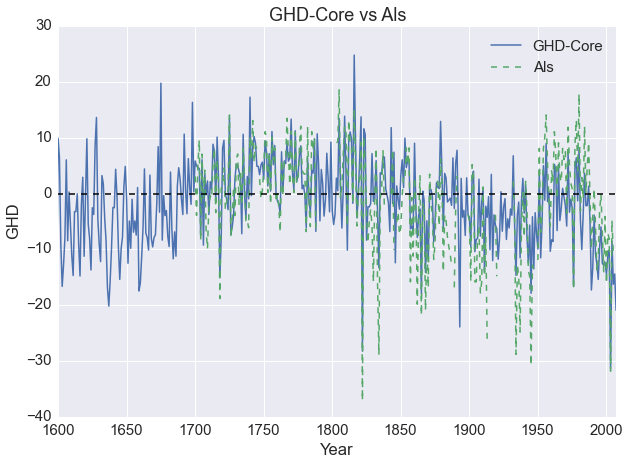

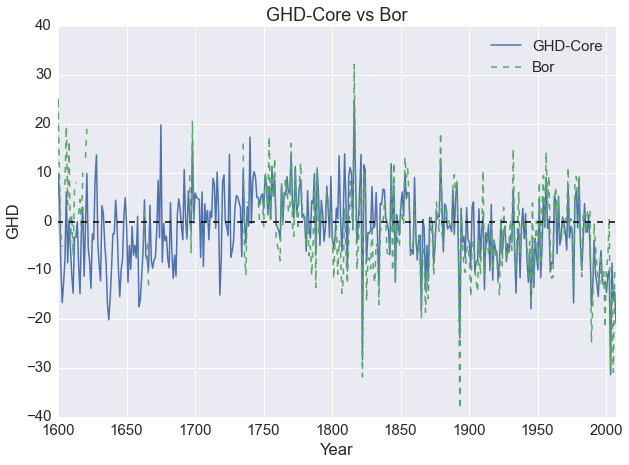

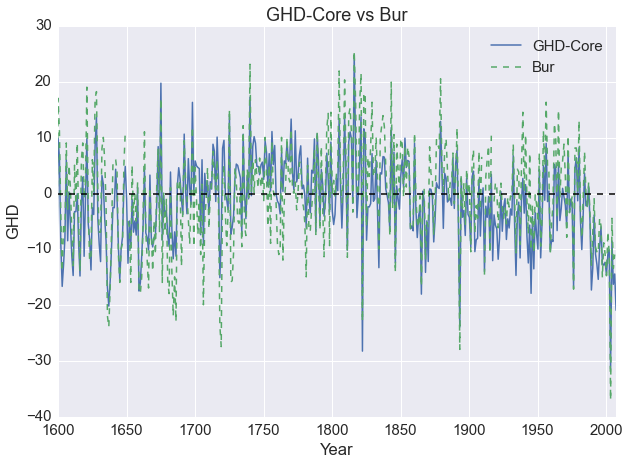

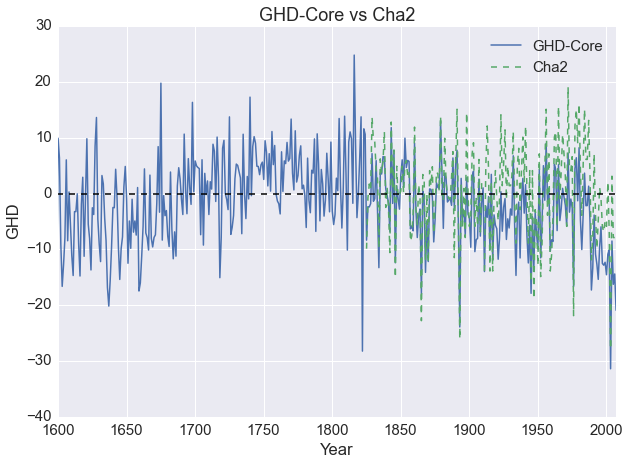

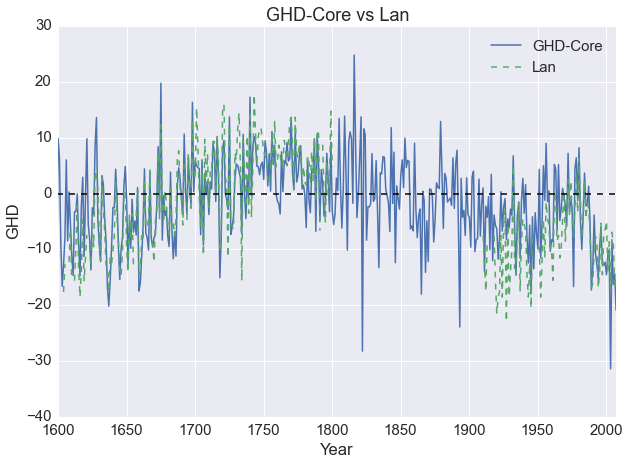

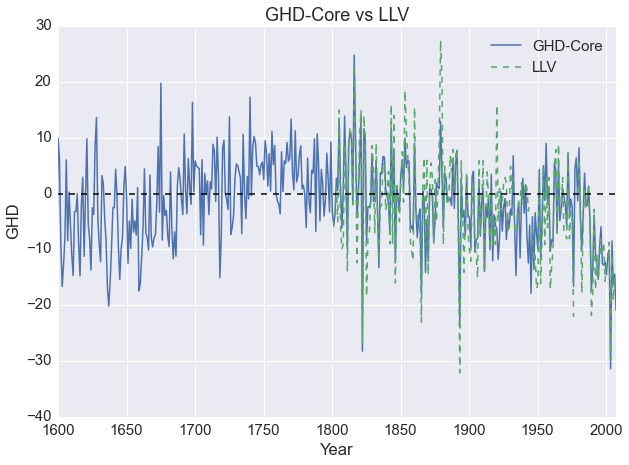

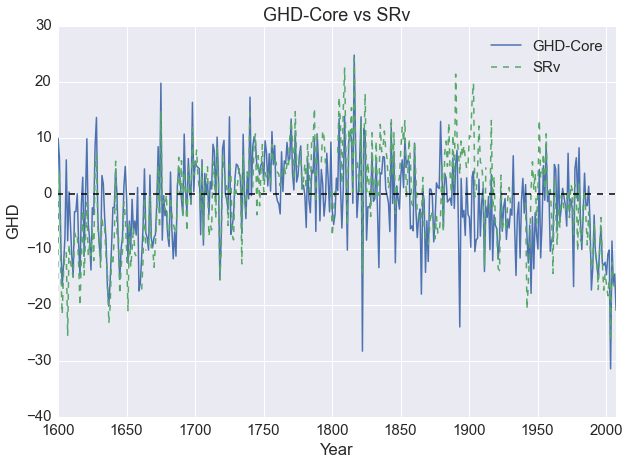

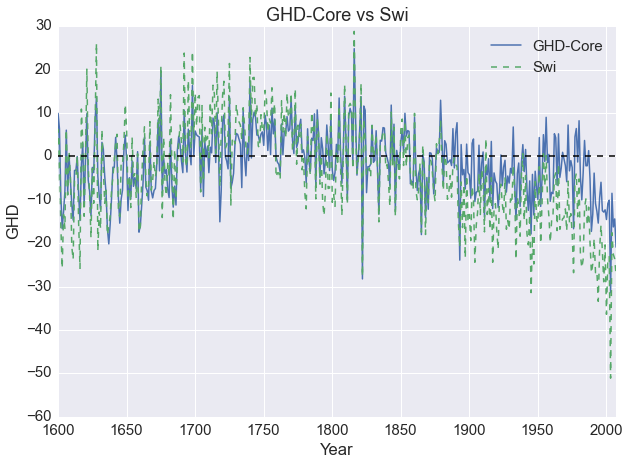

In [159]:
for num_series in enumerate(core_names):
    #print(num_series[0])

    # Series Name and Series Index
    series_name = core_names[num_series[0]]
    ghd_series  = ghd_doy_anom[:,core_locs[num_series[0]]]

    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
    sns.plt.figure(figsize=[10,7])
    sns.plt.plot(yr,ghd_mean_core)
    sns.plt.plot(yr,ghd_series,'--')
    sns.plt.plot(yr,line_zero,'--', color='k')
    sns.plt.xlabel('Year')
    sns.plt.ylabel('GHD')
    sns.plt.title('GHD-Core vs '+series_name)
    sns.plt.legend(['GHD-Core',series_name])
    sns.plt.tight_layout
    sns.plt.xlim(1600,2007)
    #sns.plt.savefig('./figures/step01/ghd_core_and_comp_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
    #sns.plt.savefig('../figures/step01/ghd_core_and_'+series_name+'_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 


## Cross site correlations (Spearman's rank) between all regional GHD series that make up GHD-Core. 

In [160]:
# Conduct correlations between different regional GHD series in the Core index

# Years to correlate (ALL YEARS)
i_corr = np.where(yr>=1300)[0]; time_corr = 'All Years';   

# Storage for all correlations (Spearman and Pearson)
rho_all_spear    = np.zeros((np.size(core_locs),np.size(core_locs))); rho_all_pears  = copy.deepcopy(rho_all_spear);
pval_all_spear   = np.zeros((np.size(core_locs),np.size(core_locs))); pval_all_pears = copy.deepcopy(pval_all_spear);

# Loop through Each Series and Compare Against Every Other One via a nested loop

# Series (1)
for num_series_1 in enumerate(core_names):
    #print(num_series[0])

    # Series (1) Name and Series Index
    series_name_1 = core_names[num_series_1[0]]
    ghd_series_1  = ghd_doy_anom[i_corr,core_locs[num_series_1[0]]]

# Series (2)
    for num_series_2 in enumerate(core_names):

        # Series (1) Name and Series Index
        series_name_2 = core_names[num_series_2[0]]
        ghd_series_2  = ghd_doy_anom[i_corr,core_locs[num_series_2[0]]]

        #print([num_series_1[0],num_series_2[0]])

        # Find Locations of Real Values in Each (not NAN, not missing)
        realvals = np.where( (~np.isnan(ghd_series_1)) & (~np.isnan(ghd_series_2)) )[0]  
        
        # Calculate Correlations (Spearman and Pearson)
        rho_all_spear[num_series_1[0],num_series_2[0]],pval_all_spear[num_series_1[0],num_series_2[0]] = \
            stats.spearmanr(ghd_series_1[realvals], ghd_series_2[realvals])

        rho_all_pears[num_series_1[0],num_series_2[0]],pval_all_pears[num_series_1[0],num_series_2[0]] = \
            stats.pearsonr(ghd_series_1[realvals], ghd_series_2[realvals])
                  
# Now, correlate core index and composite index
rho_coreVcomp,pval_coreVcomp = stats.spearmanr(ghd_mean_all[i_corr],ghd_mean_core[i_corr]) 

# Put Correlations in Dataframes
df_rho_core_spear = pd.DataFrame(rho_all_spear, index=core_names, columns=core_names)
df_rho_core_pears = pd.DataFrame(rho_all_pears, index=core_names, columns=core_names)

In [161]:
print('Spearmans Rank Correlations: '+time_corr)
print('NO DETRENDING')
print('Supplementary Table 3')
df_rho_core_spear

Spearmans Rank Correlations: All Years
NO DETRENDING
Supplementary Table 3


,Als,Bor,Bur,Cha2,Lan,LLV,SRv,Swi
Als,1.000000,0.601045,0.573844,0.632206,0.549969,0.502502,0.413751,0.604378
Bor,0.601045,1.000000,0.615465,0.675208,0.467351,0.712442,0.248981,0.553595
Bur,0.573844,0.615465,1.000000,0.798581,0.450240,0.775801,0.456186,0.562137
Cha2,0.632206,0.675208,0.798581,1.000000,0.655226,0.709044,0.346222,0.569444
Lan,0.549969,0.467351,0.450240,0.655226,1.000000,0.359080,0.764725,0.705376
LLV,0.502502,0.712442,0.775801,0.709044,0.359080,1.000000,0.456008,0.696642
SRv,0.413751,0.248981,0.456186,0.346222,0.764725,0.456008,1.000000,0.500804
Swi,0.604378,0.553595,0.562137,0.569444,0.705376,0.696642,0.500804,1.000000


In [162]:
print('Pearsons r Correlations: '+time_corr)
print('NO DETRENDING')
df_rho_core_pears

Pearsons r Correlations: All Years
NO DETRENDING


,Als,Bor,Bur,Cha2,Lan,LLV,SRv,Swi
Als,1.000000,0.624877,0.599068,0.680461,0.570141,0.525393,0.445166,0.630186
Bor,0.624877,1.000000,0.660126,0.716800,0.476346,0.761878,0.268540,0.611979
Bur,0.599068,0.660126,1.000000,0.831738,0.436710,0.810783,0.497955,0.584311
Cha2,0.680461,0.716800,0.831738,1.000000,0.603750,0.735722,0.376924,0.599031
Lan,0.570141,0.476346,0.436710,0.603750,1.000000,0.306947,0.737360,0.698598
LLV,0.525393,0.761878,0.810783,0.735722,0.306947,1.000000,0.489171,0.725922
SRv,0.445166,0.268540,0.497955,0.376924,0.737360,0.489171,1.000000,0.522562
Swi,0.630186,0.611979,0.584311,0.599031,0.698598,0.725922,0.522562,1.000000


## Create plot of sample depth for GHD-Core and GHD-All

(1354, 2007)

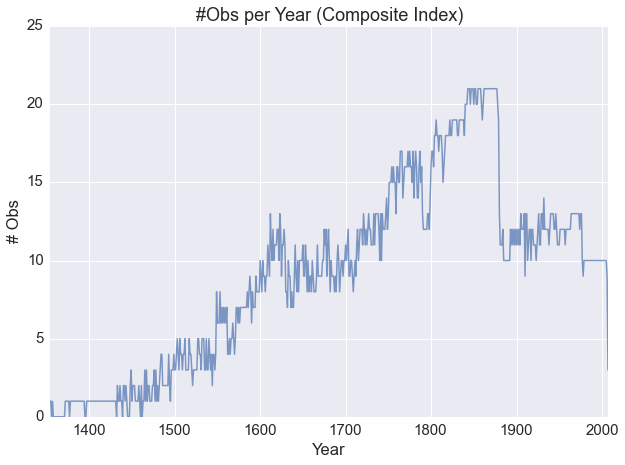

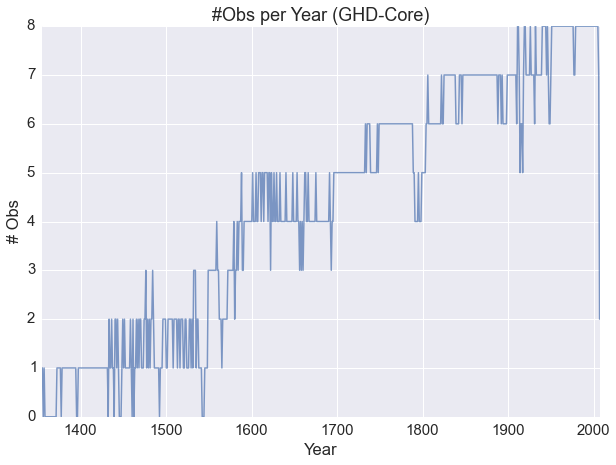

In [163]:
# Find valid (NOT NAN) Observations: Composite Index
valid_obs = ~np.isnan(ghd_doy_anom)   # Boolean indicating missing values or not
valid_obs = np.float64(valid_obs)     # Convert Boolean array to 1s and 0s

# Sum them up
num_obs = np.sum(valid_obs,axis=1)

# COMPOSITE INDEX
# Bar Plot Figure
sns.plt.figure(figsize=[10,7]) 
sns.plt.plot(yr,num_obs,'-',alpha=0.7);
sns.plt.xlabel('Year')
sns.plt.ylabel('# Obs')
sns.plt.title('#Obs per Year (Composite Index)')  
sns.plt.tight_layout
sns.plt.xlim(np.min(yr),np.max(yr))
#sns.plt.savefig('./figures/step01/num_obs_comp_index_bar.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator        
#sns.plt.savefig('../figures/step01/num_obs_comp_index_bar.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator        

# Bar plot of sample depth
# Find valid (NOT NAN) Observations: Core Index
core_all=ghd_doy_anom[:,core_locs];
valid_obs = ~np.isnan(core_all)
valid_obs = np.float64(valid_obs)

# Sum them up
num_obs = np.sum(valid_obs,axis=1)

# Sample Depth Figure
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7]) 
sns.plt.plot(yr,num_obs,'-',alpha=0.7);
sns.plt.xlabel('Year')
sns.plt.ylabel('# Obs')
sns.plt.title('#Obs per Year (GHD-Core)')  
sns.plt.tight_layout
sns.plt.xlim(np.min(yr),np.max(yr))
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/step01/num_obs_core_index_bar.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator   
#sns.plt.savefig('../figures/step01/num_obs_core_index_bar.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator   


## Find the earliest comparable non-overlapping period to compare 1981-2007 harvest dates against.

In [164]:
# Length of period
len_period = np.size(np.arange(1981,2008))

# Last year to possibly start window and be non-overlapping with 1981-2007
last_yr=2007-(len_period*1-1)

# Create vector of years to begin moving window
begyr_window = np.arange(1600,last_yr+1)

# Create a Vector to Store the Moving Window averages
ghd_window_ave = np.zeros((np.size(begyr_window),2));

# Now loop through, and pull windows of data that begin in yr begyr_window. The average them and store.
for i in enumerate(begyr_window):
    
    # Locations for current window
    loc_window = np.where( (yr>=i[1]) & (yr<=(i[1]+len_period)-1))[0]

    # Calculate mean for this window period and store   
    ghd_window_ave[i[0],0] = i[1]
    ghd_window_ave[i[0],1] = np.nanmean(ghd_mean_core[loc_window])

## Create line plot of these moving window average GHDs.

(1600, 1981)

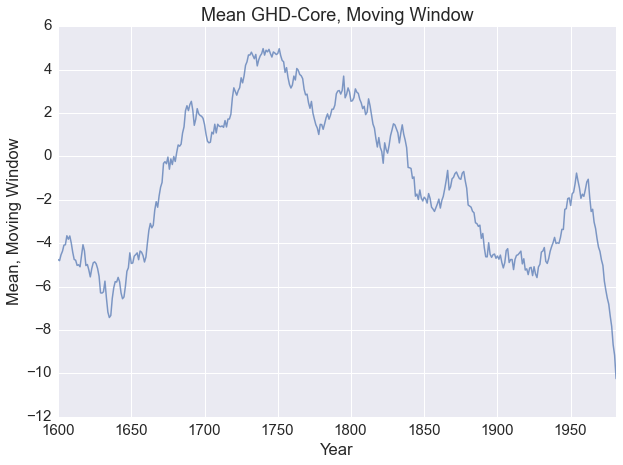

In [165]:
sns.plt.figure(figsize=[10,7]) 
sns.plt.plot(ghd_window_ave[:,0],ghd_window_ave[:,1],'-',alpha=0.7);
sns.plt.xlabel('Year')
sns.plt.ylabel('Mean, Moving Window')
sns.plt.title('Mean GHD-Core, Moving Window')  
sns.plt.tight_layout
sns.plt.xlim(np.min(begyr_window),np.max(begyr_window))
#sns.plt.savefig('./figures/step01/num_obs_comp_index_bar.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator        
#sns.plt.savefig('../figures/step01/num_obs_comp_index_bar.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator        

## Find earliest previous interval that does not overlap.

In [166]:
# Find last valid year with window that does not overlap 1981-2007
last_non_overlapping_yr = 2007-(len_period*2-1)

# Vector to trim the year
trim_yrs = np.where((ghd_window_ave[:,0]>=1600) & (ghd_window_ave[:,0]<=last_non_overlapping_yr))[0]

# Trim the Years
ghd_window_ave_trim = ghd_window_ave[trim_yrs,:]

# Find the minimum value
earliest_ghd = np.nanmin(ghd_window_ave_trim[:,1])

# Find the year of the interval this 
earliest_ghd_loc = np.where(ghd_window_ave_trim[:,1]==earliest_ghd)[0]

print("Year and Mean for Earliest Previous Interval")
print(ghd_window_ave_trim[earliest_ghd_loc,:])

# Start and End Years for this Period
yr_start = ghd_window_ave_trim[earliest_ghd_loc,0];
yr_end   = yr_start+len_period-1;

Year and Mean for Earliest Previous Interval
[[ 1635.            -7.42442284]]


## Pull out all the data from this previous earliest interval. Double check the data to make sure the dates are consistent.

In [167]:
yr_loc_earliest = np.where((yr>=yr_start) & (yr<=yr_end) )[0];

# Pull Out the Years and the GHD Values
yrs_earliest = yr[yr_loc_earliest];
ghd_earliest = ghd_mean_core[yr_loc_earliest];

print('Years')
print(yrs_earliest)
print('')
print('GHD Values')
print(ghd_earliest)
print('')
print('Mean GHD:')
print(np.nanmean(ghd_earliest))

Years
[1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649
 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661]

GHD Values
[ -8.43438851 -16.80938851 -20.15938851 -15.63438851  -9.63438851
  -2.48884414  -2.53438851   4.36561149  -0.65938851  -9.58438851
 -15.38438851  -9.85938851  -7.75938851   1.21115586   4.86561149
  -0.90572185 -12.48438851  -4.90938851  -9.80884414  -1.00938851
  -6.90938851  -4.90344297  -7.43438851   1.08702536 -17.45938851
 -16.01297464 -11.20938851]

Mean GHD:
-7.42442284342


## Plot up histograms for GHD-Core, comparing 1981-2007 against all BEFORE 1981 (1600-1980).
* Conduct a Student's t-test to assess significance.

Mean GHD (1600-1980) = -1.01945038683
Mean GHD (1981-2007) = -10.2402455264

Students t-test, 2-sided: 1600-1980 vs 1981-2007
t-stat:  6.19121232621
pval:  1.46279038372e-09


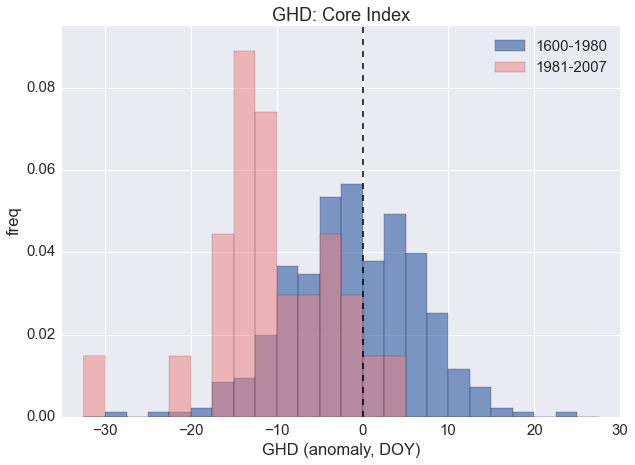

In [168]:
# Set Bin Edges   
bins=np.arange(-30,33,3); bins=np.arange(-32.5,30,2.5)

# Always use the same base period, 1600-1980
ghd_before    = ghd_mean_core[yr_loc_1600_1980]; yrs_before=copy.deepcopy(period_1600_1980)

# Modern Interval, 1981-2007
ghd_modern    = ghd_mean_core[yr_loc_1981_2007]; yrs_modern = copy.deepcopy(period_1981_2007)  
       
# Text for legend
legtxt_before    = np.str(np.min(yrs_before)) + '-' + np.str(np.max(yrs_before));
legtxt_modern    = np.str(np.min(yrs_modern)) + '-' + np.str(np.max(yrs_modern));

# HISTOGRAM
sns.plt.figure(figsize=[10,7])     
sns.plt.hist(ghd_before, bins, normed=True, alpha=0.7);
sns.plt.hist(ghd_modern, bins, normed=True, color="#F08080", alpha=.5);
#sns.plt.hist(ghd_1980_2007, bins, normed=True, color="#57AFC8", alpha=.5);
sns.plt.legend([legtxt_before,legtxt_modern])
sns.plt.plot([0,0],[0,0.10],'--', color='k')
sns.plt.xlabel('GHD (anomaly, DOY)')
sns.plt.ylabel('freq')
sns.plt.title('GHD: Core Index')  
sns.plt.tight_layout
sns.plt.ylim(0,0.095)
sns.plt.xlim(-35,30)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5}) 
#sns.plt.savefig('../figures/step01/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
#sns.plt.savefig('./figures/step01/ghd_comp_hist.'+legtxt_modern+'.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 

# Calculate mean and median
mean_modern   = np.nanmean(ghd_modern)
mean_before   = np.nanmean(ghd_before)

print('Mean GHD (1600-1980) = '+np.str(mean_before))
print('Mean GHD (1981-2007) = '+np.str(mean_modern))
print('')
# Two Sided Student's T-test results (most recent period vs all previous)
tt_ghd = stats.ttest_ind(ghd_before, ghd_modern)

print('Students t-test, 2-sided: 1600-1980 vs 1981-2007')
print('t-stat: ',tt_ghd[0])
print('pval: ',tt_ghd[1])

## Plot up histograms for GHD-Core, comparing 1981-2007 against 1635-1661 (earliest previous interval of the same length).
* Conduct a Student's t-test to assess significance.

Mean GHD (1635-1661) = -7.42442284342
Mean GHD (1981-2007) = -10.2402455264

Students t-test, 2-sided: 1635-1661 vs 1981-2007
t-stat:  1.46160404931
pval:  0.149866886937
1-sided pval:  0.0749334434685


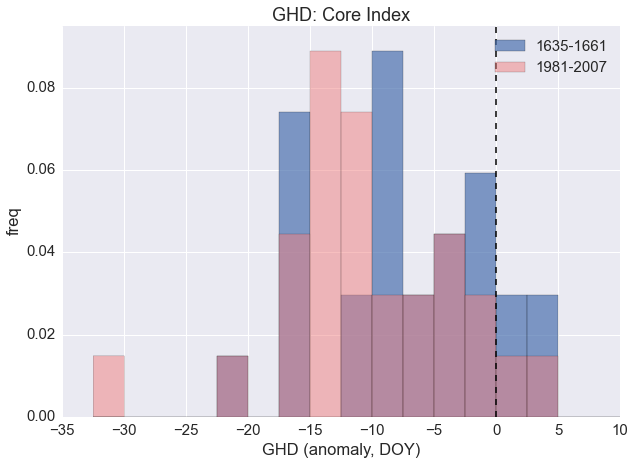

In [169]:
# Set Bin Edges   
bins=np.arange(-30,33,3); bins=np.arange(-32.5,30,2.5)

# Always use the same base period, 1635-1661
ghd_before    = copy.deepcopy(ghd_earliest); yrs_before=copy.deepcopy(yrs_earliest)

# Modern Interval, 1981-2007
ghd_modern    = ghd_mean_core[yr_loc_1981_2007]; yrs_modern = copy.deepcopy(period_1981_2007)  
       
# Text for legend
legtxt_before    = np.str(np.min(yrs_before)) + '-' + np.str(np.max(yrs_before));
legtxt_modern    = np.str(np.min(yrs_modern)) + '-' + np.str(np.max(yrs_modern));

# HISTOGRAM
sns.plt.figure(figsize=[10,7])     
sns.plt.hist(ghd_before, bins, normed=True, alpha=0.7);
sns.plt.hist(ghd_modern, bins, normed=True, color="#F08080", alpha=.5);
#sns.plt.hist(ghd_1980_2007, bins, normed=True, color="#57AFC8", alpha=.5);
sns.plt.legend([legtxt_before,legtxt_modern])
sns.plt.plot([0,0],[0,0.10],'--', color='k')
sns.plt.xlabel('GHD (anomaly, DOY)')
sns.plt.ylabel('freq')
sns.plt.title('GHD: Core Index')  
sns.plt.tight_layout
sns.plt.ylim(0,0.095)
sns.plt.xlim(-35,10)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5}) 
#sns.plt.savefig('../figures/step01/ghd_core_hist.'+legtxt_modern+'.vs.'+legtxt_before+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
#sns.plt.savefig('./figures/step01/ghd_comp_hist.'+legtxt_modern+'.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 

# Calculate mean and median
mean_modern   = np.nanmean(ghd_modern)
mean_before   = np.nanmean(ghd_before)

print('Mean GHD (1635-1661) = '+np.str(mean_before))
print('Mean GHD (1981-2007) = '+np.str(mean_modern))
print('')
# Two Sided Student's T-test results (most recent period vs all previous)
tt_ghd = stats.ttest_ind(ghd_before, ghd_modern)

print('Students t-test, 2-sided: 1635-1661 vs 1981-2007')
print('t-stat: ',tt_ghd[0])
print('pval: ',tt_ghd[1])
print('1-sided pval: ',tt_ghd[1]/2)

## Store GHD anomaly data in a new dataframe.
* Save this output to a new comma delimited text file.
* Moving forward, this is the data file I will use for subsequent analyses.

In [170]:
df_ghd_anom = pd.DataFrame(data=ghd_doy_anom, index=yr, columns=df.columns)

# Add new dummy columns for core and composite index
df_ghd_anom["GHDmean"] = np.nan
df_ghd_anom["GHDcore"] = np.nan

# Fill this duymmy column with the mean values
df_ghd_anom.GHDmean = ghd_mean_all
df_ghd_anom.GHDcore = ghd_mean_core

# Name the Index
df_ghd_anom.index.name='Year'

# Save GHD for all sites (and composite and core), converted to GHD anomalies
outfile = '../data/ghd_anom_doy_v02.csv'    # name of output file
if os.path.exists(outfile):
    os.remove(outfile); 
df_ghd_anom.to_csv(outfile,sep=',')    # save to file

## Save output: the lat/lon locations of the GHD-Core sites.
* I will use this data to generate a map of site locations.

In [171]:
# Save Output: Locations of Core Index Sites

# First, read in locations for all sites
infile = '../data/site_locs.csv'   # Name of the data file
df=pd.read_csv(infile)
lat_all=np.float64(df['Latitude'])
lon_all=np.float64(df['Longitude'])

# Pull out lat/lon locations for Core Sites
df_out_locs = df.iloc[core_locs,0:3]
df_out_locs

# Save Locations to a csv file
outfile = '../data/site_locs_core_v02.csv'    # name of output file
if os.path.exists(outfile):
    os.remove(outfile); 
df_out_locs.to_csv(outfile,sep=',')    # save to file

print("Lat/Lon for GHD-Core Sites")
df_out_locs

Lat/Lon for GHD-Core Sites


,Location,Latitude,Longitude
0,Als,48.17,7.28
4,Bor,45.18,-0.75
5,Bur,47.32,5.04
7,Cha2,47.98,4.28
13,Lan,43.60,3.87
14,LLV,47.15,0.22
23,SRv,43.98,5.05
24,Swi,46.57,6.52


In [172]:
print("DONE!")
print("Last run: "+str(datetime.datetime.now()))

DONE!
Last run: 2015-12-11 12:14:28.969135
